In [10]:
#
# Chapter 7, example 3
#

import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers, models
import pylab
import utils
import os

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')
    
# Check the version of Tensorflow (2.2.0)
print(tf.__version__)

2.2.0


In [11]:
# Load and prepare the MNIST dataset. 
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# choose 12000 images for training, 2000 images for testing
x_train,y_train = x_train[:12000],y_train[:12000]
x_test,y_test = x_test[:2000],y_test[:2000]
# Convert the samples from integers to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)
# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(12000, 28, 28)
(2000, 28, 28)
(12000, 28, 28, 1)
(2000, 28, 28, 1)


In [12]:
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128)

In [13]:
# Built Model
tf.keras.backend.set_floatx('float64')
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # Convert the samples from integers to [0,1]
        # layers.experimental.preprocessing.Rescaling(1./255, input_shape=(28, 28, 1)),
        # First convolutional layer - maps one grayscale image to 32 feature maps.
        self.conv1 = layers.Conv2D(32, 5, padding='SAME', activation='relu', use_bias=True)
        # First Pooling layer - downsamples by 2X.
        self.p1 = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='SAME')
        # Second convolutional layer -- maps 32 feature maps to 64.
        self.conv2 = layers.Conv2D(64, 5, padding='SAME', activation='relu', use_bias=True)
        # Second Pooling layer - downsamples by 2X.
        self.p2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='SAME')
        # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
        # is down to 7x7x64 feature maps -- maps this to 1024 features.
        self.flatten = layers.Flatten()
        self.d1 = layers.Dense(1024, activation='relu')
        # dropout layer
        self.drop = tf.keras.layers.Dropout(0.2)
        # softmax
        self.d2 = layers.Dense(10, activation='softmax')
    def call(self, x):
        conv1 = self.conv1(x)
        p1 = self.p1(conv1)
        conv2 = self.conv2(p1)
        p2 = self.p2(conv2)
        flatten = self.flatten(p2)
        d1 = self.d1(flatten)
        drop = self.drop(d1)
        out = self.d2(drop)
        return conv1, p1, conv2, p2, out

# Create an instance of the model
model = MyModel()

In [14]:
# Choose an optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [15]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [16]:
# Train step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        _,_,_,_,predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [17]:
# Test step
@tf.function
def test_step(images, labels):
    _,_,_,_,predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [18]:
# Main function: train and test the model
EPOCHS = 100
test_acc = []
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    test_acc.append(test_accuracy.result())
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))


Epoch 1, Loss: 2.295058473627618, Accuracy: 0.12283333333333334, Test Loss: 2.2874236702919006, Test Accuracy: 0.1515
Epoch 2, Loss: 2.2793316765034453, Accuracy: 0.20866666666666667, Test Loss: 2.2727104127407074, Test Accuracy: 0.2355
Epoch 3, Loss: 2.262862093905185, Accuracy: 0.275, Test Loss: 2.2569140791893005, Test Accuracy: 0.312
Epoch 4, Loss: 2.2446095765905176, Accuracy: 0.3516666666666667, Test Loss: 2.2390107065439224, Test Accuracy: 0.376
Epoch 5, Loss: 2.2234917295740004, Accuracy: 0.4013333333333333, Test Loss: 2.217884048819542, Test Accuracy: 0.445
Epoch 6, Loss: 2.1980624173549894, Accuracy: 0.46991666666666665, Test Loss: 2.1921756863594055, Test Accuracy: 0.518
Epoch 7, Loss: 2.166424261762741, Accuracy: 0.5394166666666667, Test Loss: 2.159798875451088, Test Accuracy: 0.5855
Epoch 8, Loss: 2.1257768108489667, Accuracy: 0.6099166666666667, Test Loss: 2.117827996611595, Test Accuracy: 0.643
Epoch 9, Loss: 2.0726129032195884, Accuracy: 0.66925, Test Loss: 2.0624594092

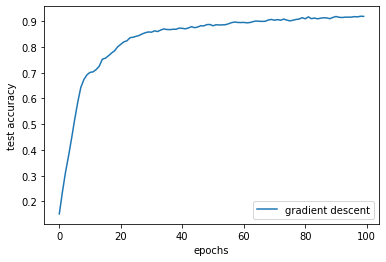

In [19]:
pylab.figure()
pylab.plot(np.arange(EPOCHS), test_acc, label='gradient descent')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')
pylab.savefig('./figures/7.3_1.png')

(5, 5, 1, 32)


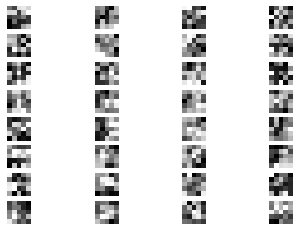

In [20]:
# get filters learned at the first conv layer
filters_conv1 = model.conv1.get_weights()[0]
print(filters_conv1.shape)
pylab.figure()
pylab.gray()
for i in range(32):
    pylab.subplot(8, 4, i+1); pylab.axis('off'); pylab.imshow(filters_conv1[:,:,0,i])
pylab.savefig('./figures/7.3_2.png')

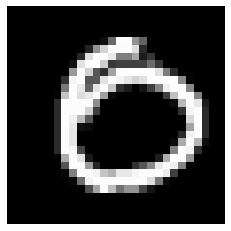

In [21]:
# Select and show a random sample
seed = 1
np.random.seed(seed)
ind = np.random.randint(0,2000)
x = x_test[ind,:]
conv1, p1, conv2, p2, out = model(x[tf.newaxis,...])

pylab.figure()
pylab.gray()
pylab.axis('off'); 
pylab.imshow(x.reshape(28,28))
pylab.savefig('./figures/7.3_3.png')

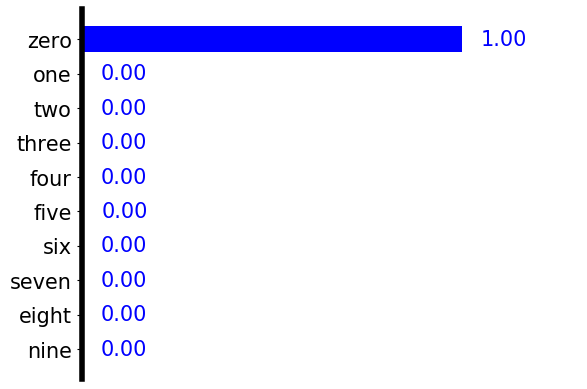

In [22]:
# Display visually the predicted confidence scores
utils.show_prob_mnist(np.array(out)[0])

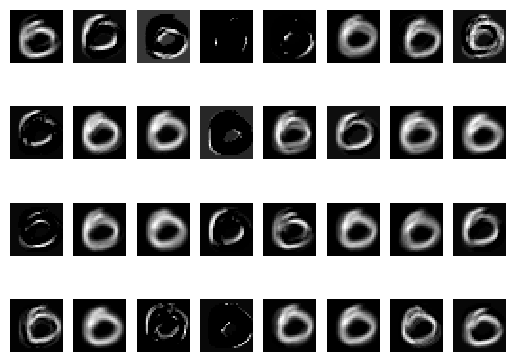

In [23]:
# Show feature maps at conv1
pylab.figure()
pylab.gray()
conv1 = np.array(conv1)
for i in range(32):
    pylab.subplot(4, 8, i+1); pylab.axis('off'); pylab.imshow(conv1[0,:,:,i])
pylab.savefig('./figures/7.3_4.png')

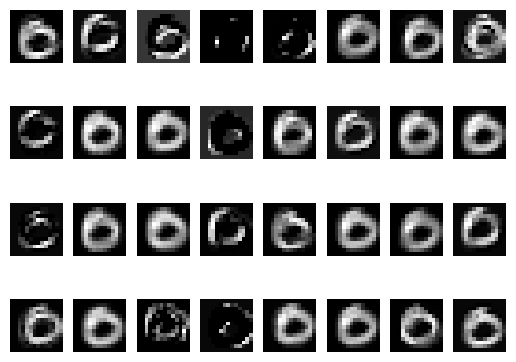

In [24]:
# Show feature maps at pooling1
pylab.figure()
pylab.gray()
p1 = np.array(p1)
for i in range(32):
    pylab.subplot(4, 8, i+1); pylab.axis('off'); pylab.imshow(p1[0,:,:,i])
pylab.savefig('./figures/7.3_5.png')

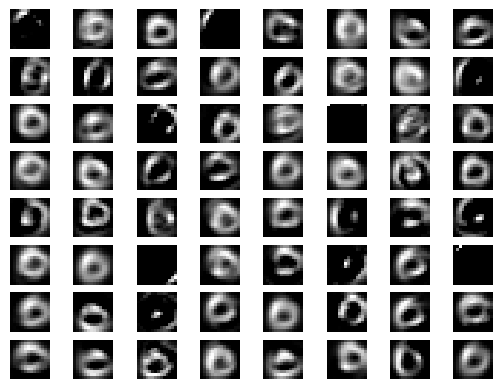

In [25]:
# Show feature maps at conv2
pylab.figure()
pylab.gray()
conv2 = np.array(conv2)
for i in range(64):
    pylab.subplot(8, 8, i+1); pylab.axis('off'); pylab.imshow(conv2[0,:,:,i])
pylab.savefig('./figures/7.3_6.png')

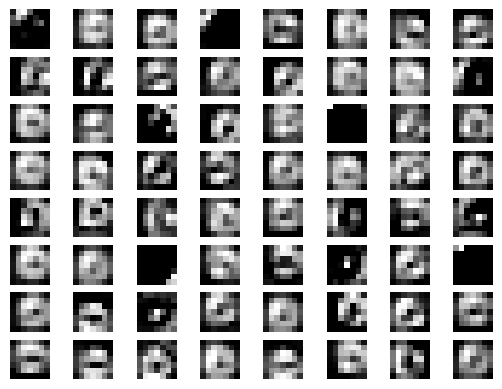

In [26]:
# Show feature maps at pooling2
pylab.figure()
pylab.gray()
p2 = np.array(p2)
for i in range(64):
    pylab.subplot(8, 8, i+1); pylab.axis('off'); pylab.imshow(p2[0,:,:,i])
pylab.savefig('./figures/7.3_7.png')